# Problem Set 3

In [193]:
# Numpy, scipy for data manipulation
import numpy as np
import scipy as sc

# Matplotlib for plotting
from matplotlib import pyplot as plt

from sympy import pretty_print as pp, latex

import camb
import corner

# Push interactive figures into Jupyter
%matplotlib inline 

import json
config = json.load(open('matplotlib_config.json'))
plt.rcParams.update(config)
plt.rcParams['figure.figsize'] = (20,10)

# Direct Markdown
from IPython.display import Markdown as md

In [190]:
%matplotlib notebook 

In [3]:
# Import the data
a = np.loadtxt("TT_power_spectra.txt").T

# Unpack the data
col1,col2,col3,col4,col5 = a # Ignore col4 and col5

# CMB calulator

The following function returns the measured variance of the sky as a function of multipole $\ell$, 
given the following paramters:

$\cdot$ Hubble Constant $H_0$

$\cdot$ Physical baryon density $\omega_bh^2$

$\cdot$ Cold dark matter density $\omega_ch^2$

$\cdot$ Optical Depth $\tau$

$\cdot$ Primordial amplitude of fluctuations $A_s$

$\cdot$ Slope of the primordial power law 


In [168]:
def get_cmb(params,tau = 0.05,lmax=2000):
    
    if (tau_fixed):
        H0,ombh2,omch2,As,ns = params
    else:
        H0,ombh2,omch2,tau,As,ns = params

    params = camb.CAMBparams()
    params.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    params.InitPower.set_params(As=As,ns=ns,r=0)
    params.set_for_lmax(lmax,lens_potential_accuracy=0)
    
    results = camb.get_results(params)
    powers = results.get_cmb_power_spectra(params,CMB_unit='muK')
    cmb = powers['total']
    cmb = cmb[:,0]  
    
    # Remove the monopole and dipole
    cmb = cmb[2:]
    
    return cmb

## Problem 1) 

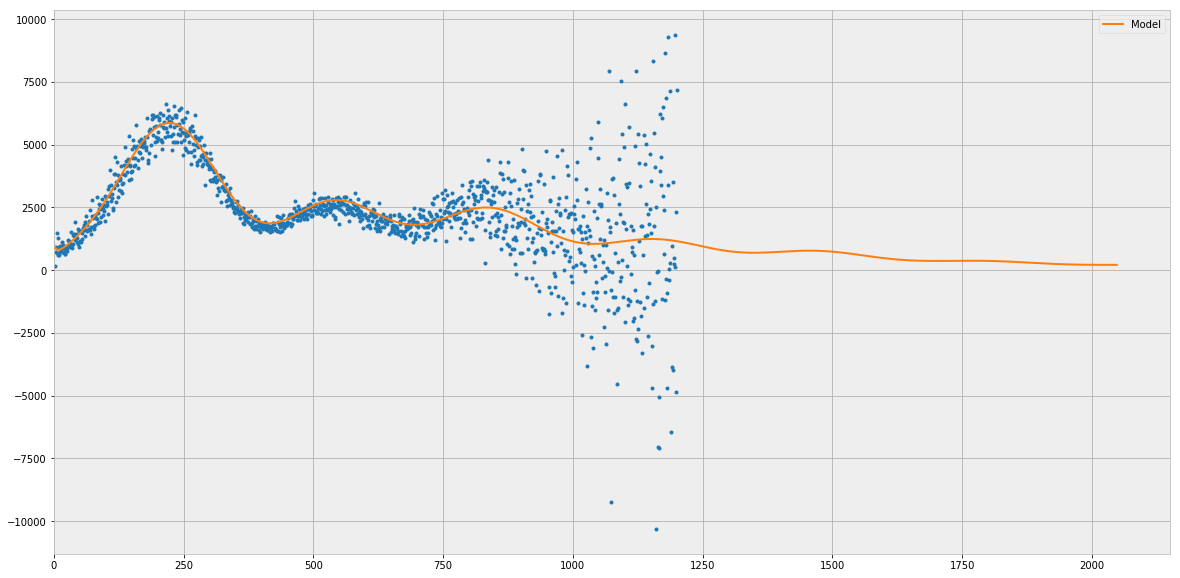

$\chi^2 = 1588.237647$

In [169]:
tau_fixed = False

plt.figure()

# CMB parameters
pars = np.asarray([65,0.02,0.1,0.05,2e-9,0.96])

# Calculate the CMB from the parameters above.
cmb = get_cmb(pars)

# Plot the data
plt.plot(col1,col2,'.')

# Plot the calculated model
plt.plot(cmb, label = "Model")

# Setup the plot
plt.xlim(0)
plt.legend()
plt.show()

# Calculate Chi-Sqaure
r = (col2-cmb[:1199])/col3
chisq = (r**2).sum()

# Display the Chi-Sqaure to the user
md("$\chi^2 = %f$"%(chisq))

## Problem 2)

In [234]:
p0 = np.asarray([65,0.02,0.1,2e-9,0.96]) #np.asarray([65,0.02,0.1,2e-9,0.56])

In [240]:
def calc_grad(p,l):
    y0 = get_cmb(p)
    # Small increment used to calculate the derivative of the get_cmb function with 
    # respect to each parameter
    dx = p/1000
    grad = np.zeros([y0.size,p.size])

    grad[:,0]= ( get_cmb(p+[dx[0],0,0,0,0]) - y0 )/dx[1]
    grad[:,1]= ( get_cmb(p+[0,dx[1],0,0,0]) - y0 )/dx[1]
    grad[:,2]= ( get_cmb(p+[0,0,dx[2],0,0]) - y0 )/dx[2]
    grad[:,3]= ( get_cmb(p+[0,0,0,dx[3],0]) - y0 )/dx[3]
    grad[:,4]= ( get_cmb(p+[0,0,0,0,dx[4]]) - y0 )/dx[4]
    
    return y0[:l.size],grad[:l.size]

p =  [6.49991560e+01 2.19518816e-02 1.21112254e-01 2.08254618e-09
 9.44356575e-01]
Cycle 1: χ^2 = 1588.237647

p =  [6.49985601e+01 2.20338879e-02 1.21797268e-01 2.08002407e-09
 9.49551042e-01]
Cycle 2: χ^2 = 1236.580885

p =  [6.49979679e+01 2.20354618e-02 1.21712186e-01 2.07945452e-09
 9.49641886e-01]
Cycle 3: χ^2 = 1232.546517

p =  [6.49973591e+01 2.20321458e-02 1.21837791e-01 2.08015983e-09
 9.49408806e-01]
Cycle 4: χ^2 = 1232.595541

p =  [6.49967555e+01 2.20303697e-02 1.21777197e-01 2.07976218e-09
 9.49474305e-01]
Cycle 5: χ^2 = 1232.548484

p =  [6.49961483e+01 2.20309952e-02 1.21823883e-01 2.08006917e-09
 9.49410867e-01]
Cycle 6: χ^2 = 1232.557310

p =  [6.49955583e+01 2.20351704e-02 1.21700616e-01 2.07939009e-09
 9.49656550e-01]
Cycle 7: χ^2 = 1232.550112

p =  [6.49949496e+01 2.20314883e-02 1.21840153e-01 2.08017113e-09
 9.49396614e-01]
Cycle 8: χ^2 = 1232.604842

p =  [6.49943603e+01 2.20353280e-02 1.21698066e-01 2.07937547e-09
 9.49662226e-01]
Cycle 9: χ^2 = 1232.551721

p

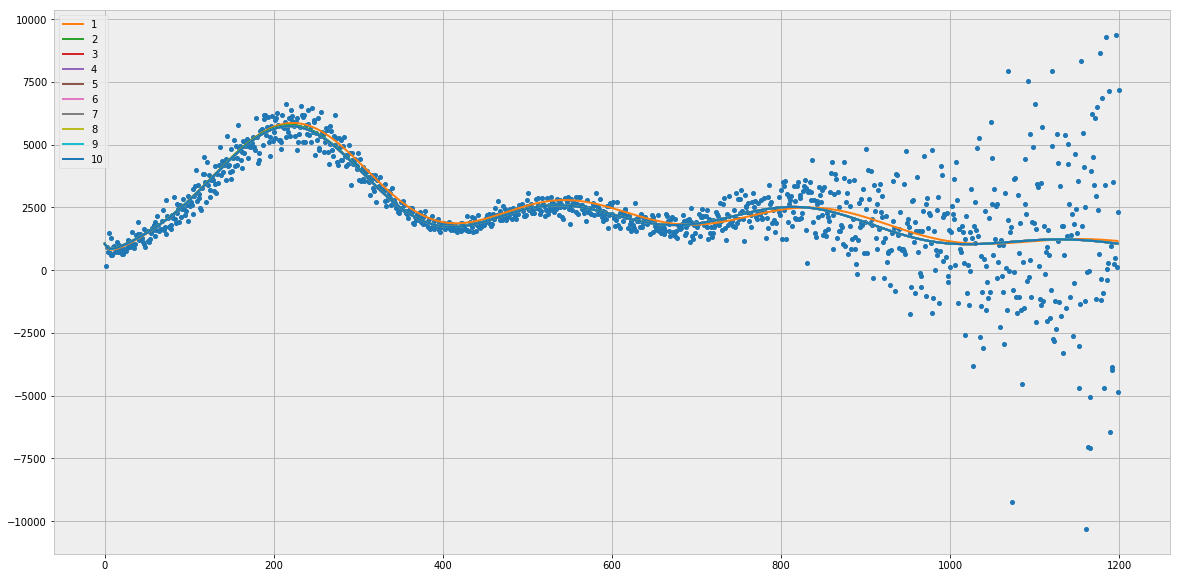

In [241]:
tau_fixed = True
# Load in the initial guess at the best fit parameters
p = p0.copy()
# Set the number of cycles of the Gauss-Newton algorithm
n_tries = 10

plt.figure()
plt.plot(col1,col2,'o', markersize = 4)

# Impliment the Gauss-Newton algorithm 
for j in range(n_tries):
    
    pred,grad = calc_grad(p,col1)
    plt.plot(pred, label = "%d"%(j+1))
    r = col2-pred
    err = (r**2).sum()
    chisq = (((col2-pred)/col3)**2).sum()
    r = np.matrix(r).transpose()
    grad = np.matrix(grad)

    lhs = grad.transpose()*grad
    rhs = grad.transpose()*r
    
    # Calculate parameter step
    dp = np.linalg.inv(lhs)*(rhs)
    # Step each parameter
    for i in range(p.size):
        p[i] = p[i]+dp[i]
    print("p = ",p)
    print("Cycle %d: χ^2 = %f"%(j+1,chisq))
    print()
plt.legend()
plt.show()

## Problem 3

In [270]:
def model(theta,lmax=2000):
    H0,ombh2,omch2,tau,As,ns = theta
    
    # CAMB initialization 
    params = camb.CAMBparams()
    params.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    params.InitPower.set_params(As=As,ns=ns,r=0)
    params.set_for_lmax(lmax,lens_potential_accuracy=0)
    
    results = camb.get_results(params)
    powers = results.get_cmb_power_spectra(params,CMB_unit='muK')
    cmb = powers['total']
    cmb = cmb[:,0]  
    
    # Remove the monopole and dipole
    cmb = cmb[2:]
    #
    return cmb[:1199]

In [271]:
# Used to check that a paramters is properly constrained (as required physically!)
def bounds(theta):
    H0,ombh2,omch2,tau,As,ns = theta
    if tau >= 0.:
        return False
    return True

In [272]:
# Simple function to calculate Χ^2
def get_chisq(data,model,sigma):
    chisq = np.sum((data-model)**2/sigma**2)
    return chisq

In [273]:
# Get the next potential step in the chain
def get_step(step_size):
    # Take a Gaussian step
    step = np.random.randn(len(step_size))*step_size
    return step

In [274]:
# Take a "first step" to get a guess for our parameters
step_size = np.array([65,0.02,0.1,0.055,2e-9,0.96])/130

theta = []
theta.append(np.array([65,0.02,0.1,0.05,2e-9,0.96]))

x,y,error = col1,col2,col3

# Setup an array of chisq to keep track of its history as we walk around in parameter space
chisq = []
chisq.append(get_chisq(y,model(theta[0]),error))

# Number of links in the chain
nstep = 1000

# Counters 
steps_taken = 0
iteration = 0

# MCMC Chain
If $\Delta \chi^2 < 0$: Take the step, as $\chi^2$ improved! 

If $\Delta \chi^2 > 0$: $\chi^2$ got worse, but we take the step with a calculated probability.

In [ ]:
# Open a log file.
f = open("live_MCMC.txt","w")
try:
    while (steps_taken < nstep):
        f.write("Iteration %d:\n\n"%iteration)
        
        # Update paramters
        iteration += 1
        new_theta = theta[-1] + get_step(step_size)
        check = bounds(new_theta)

        # Check physical boundaries on parameter values
        if(check):
            f.write("Physical boundaries violated, step not accepted!\n")
            f.write("----------------------------------------------------------------------------------------------\n")
            continue

        # Calculate the new cmb and its Χ^2 with the data
        new_cmb = model(new_theta)
        new_chisq = get_chisq(y, new_cmb, error)

        # Calculate ΔΧ^2
        delta_chisq = new_chisq - chisq[-1]
        f.write("ΔΧ^2 = %f\n"%delta_chisq)
        prob_step = np.exp(-0.5*delta_chisq)

        # Determine whether or not the step is accepted.
        accept = (np.random.rand(1) < prob_step)

        if (accept):
            theta.append(new_theta)
            chisq.append(new_chisq)
            steps_taken += 1
            f.write("Step accepted!\n\n")
        else:
            f.write("Step not accepted.\n\n")

        # Calculate the acceptance rate of steps
        acceptance_rate = steps_taken/(iteration)

        # Print information in a log file
        f.write("Currently on step %d out of %d.\n"%(steps_taken,nstep))
        f.write("Current acceptance rate = %.2f %%\n\n"%(acceptance_rate*100))
        f.write("----------------------------------------------------------------------------------------------\n")
        f.flush()
except KeyboardInterrupt:
    print('Interrupted')
    f.close()
f.close()

In [250]:
chisq

[1588.2376465826746,
 1455.176823893901,
 1406.9586753055892,
 1348.2404442450468,
 1336.872268485858,
 1317.504796108692,
 1298.5223732887764,
 1287.2134982143316,
 1280.030763553111,
 1258.899487032601,
 1249.30517607759,
 1248.066716041671,
 1241.7351682577,
 1243.8300260487838,
 1243.1770096787436,
 1236.442431897445,
 1238.387450176957,
 1239.7227998467636,
 1240.339154015352,
 1238.3095522201934,
 1239.7798186651994,
 1241.0408816518407,
 1237.5156158209838,
 1239.323528260174,
 1243.204469075596,
 1238.9492589595989,
 1241.5023540366992,
 1240.8303552236064,
 1239.449566611711,
 1241.572778278481,
 1246.8193167359786,
 1248.2428861268654,
 1248.2953322645335,
 1247.4281560441987,
 1248.2167801026208,
 1239.4051850546025,
 1243.938896134739,
 1245.6672329501885,
 1245.4000673900555,
 1241.4348760943972,
 1241.1459705034133,
 1238.7422722681576,
 1239.5752646862318,
 1240.4577876308551,
 1238.2784565315399,
 1236.5561123944713,
 1233.9240914858306,
 1234.5844765923734,
 1233.81913

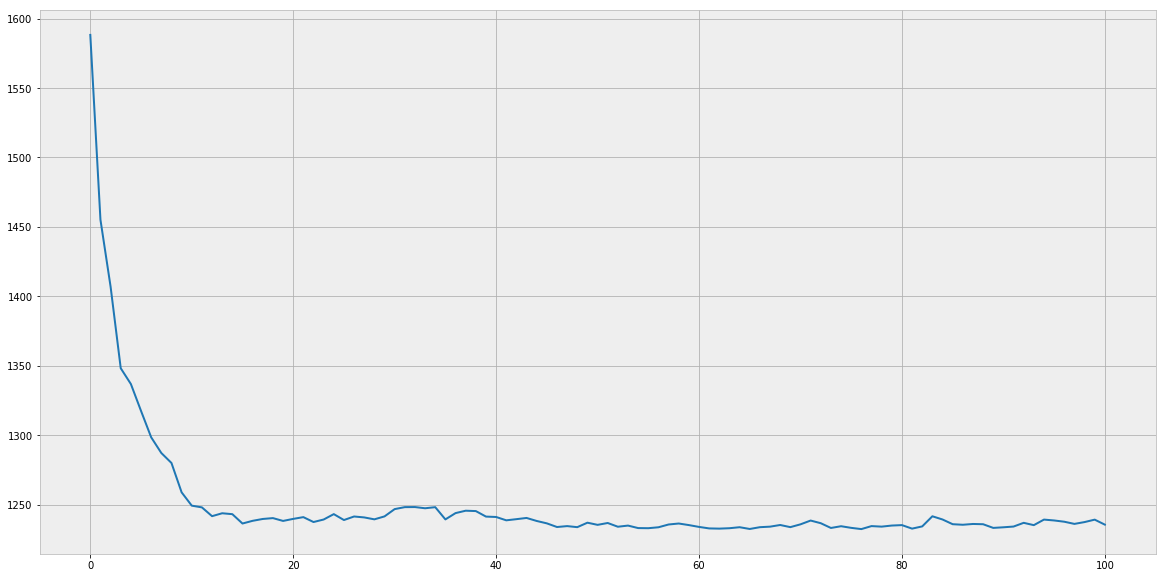

In [249]:
plt.figure()
plt.plot(chisq)
plt.show()

In [149]:
chisq2 = chisq
theta2 = theta

In [159]:
%matplotlib inline

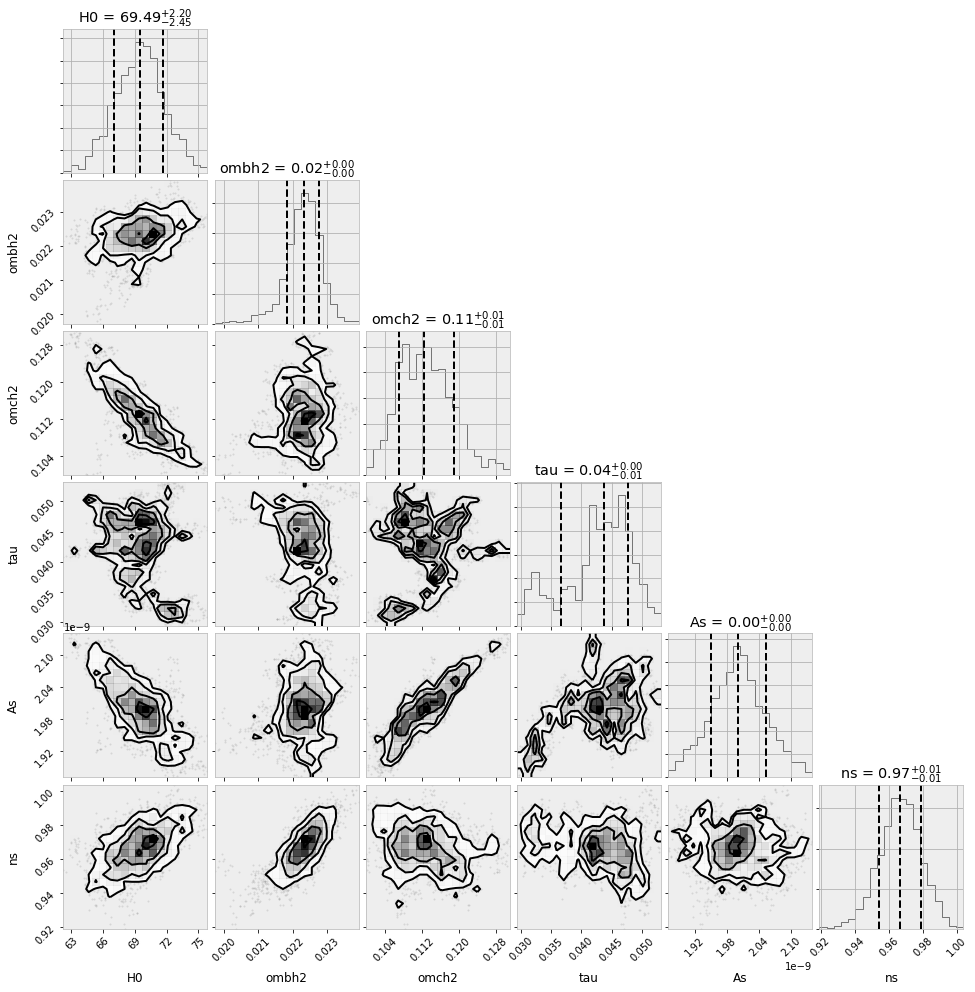

In [164]:
theta = np.array(theta)
corner.corner(theta,labels=["H0","ombh2","omch2","tau","As","ns"],show_titles=True,quantiles=[0.16, 0.5, 0.84],title_fmt='.2f')
plt.show()

In [256]:
a = np.array([6.94737433*10,2.24919083e-2,1.13600988e-1,4.00549618e-2,2e-9,9.69652633e-1])

In [257]:
p0

array([6.5e+01, 2.0e-02, 1.0e-01, 2.0e-09, 9.6e-01])

In [258]:
tau_fixed = False
b = get_cmb(a)

In [259]:
b = b[:1199]

In [268]:
tau_fixed = False
c = get_chisq(col2,get_cmb(a)[:1199],col3)

In [269]:
c

1227.9390763426916